#Introduction to NLP in tensorflow
NLP has a goal of deriving information out of natural language(could be sequences or speech)
Another common tern for NLP problem is sequence to sequence problems (seq2seq)

Training set: You show the child a bunch of labeled pictures of fruits (e.g., apple, banana, orange). This is the training set, and the child learns to recognize features of each fruit.


Validation set: Now, you show the child a few more pictures of fruits without labels and ask them to identify the fruits. This is the validation set, and you use it to check how well the child is learning and adjust your teaching methods if needed.


Test set: Finally, you give the child a completely new set of fruit pictures they've never seen before and ask them to identify the fruits. This is the test set, which evaluates the child's final ability to recognize fruits in the real world.

In [1]:
##Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
#Get helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

##Get a text dataset
Kaggles Introduction to NLP dataset(text samples of tweets labelled as disaster or not disaster)

In [3]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-10-06 07:17:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2024-10-06 07:17:34 (68.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



##Become one with the data


###Visualizing a text data

To visualize our text samples we first have to read them in python

Another is to use pandas

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [6]:
#Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)#fract tells how many percent to shuffle
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [7]:
#Test dataframe looks like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
#How many are there in each class
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [9]:

# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
my school just put the evacuation alarms on accidently with 2 different trial exams happening are you kidding me

---

Target: 1 (real disaster)
Text:
Water main break disrupts trolley service http://t.co/kff8ojrZP4 #sandiego http://t.co/JoB4GGtpAl

---

Target: 0 (not real disaster)
Text:
Love God more than you fear hell

---

Target: 0 (not real disaster)
Text:
If Schwarber ran into me going that fast I would explode into pieces

---

Target: 1 (real disaster)
Text:
FCO Minister @Tobias_Ellwood condemns attack at a mosque in Saudi Arabia that has resulted in at least 15 deaths http://t.co/c3W95h0ozZ

---



In [11]:
len(train_df_shuffled)

7613

###Split data into training and validation set

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [14]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
len(train_df_shuffled)

7613

In [16]:
len(test_df)

3263

In [17]:
#Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

##Converting text into numbers

#### tokenization -- straight mapping from token to number(token could be a word or character)
#### Embedding-- can limit size + can be learned(Create a matrix of feature vector for each token and size of image can be changed)

When dealing with a text problem one thing before model is to conver text to numbers

Few ways are tokenization and embedding

In [18]:
### Text vectorization (Tokenization)
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # TextVectorization is no longer in the experimental module

# $Use the default text vextorization parameter
text_vectorizer = TextVectorization(max_tokens=10000,  #Defines words in the vocaboluray
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,#Create word of n-words
                                    output_mode="int",#How to map tokens to numbers,
                                    output_sequence_length=None,#How long you want your sequences to be
                                    pad_to_max_tokens=True)

In [19]:
#Find the average bo of tokwns (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# @title Default title text
#Setup text vectorization variables
max_vocab_length  =10000 #Max no of words to have in vocabulary
max_length = 15#Average=MAX length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
#Fit the text vectorizer to training text
text_vectorizer.adapt(train_sentences)

In [22]:
#Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In the above six words are vectorized and 0 are padded

In [23]:
#Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEcorized_version:")
text_vectorizer([random_sentence])

Original text:
 Did you miss the #BitCoin explosion - Don't miss out - #Hangout tonight at 8:30PM EST ===&gt;&gt;&gt; http://t.co/qKaHXwLWXa        

Ecorized_version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 145,   12, 1121,    2, 6097,  303,   63, 1121,   36,    1,  383,
          17,    1,    1, 2440]])>

In [24]:
#Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() #Get all of the unique words in the training data
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


###Creating an Embedding using an Embedding Layer

* input_dim - size of the vocabulary
* output_dim - size of the output embedding vector
* input_length - length of the sequences being passed to embedding layer


In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, #input shape
                            output_dim=128,#output shape
                            input_length=max_length #How long is each input
                            )
embedding

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [26]:
#GEt a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

 #Embed the random sentences (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer ([random_sentence]))
sample_embed

Original text:
 @gregorysanders @USDOT &amp; the stat of high auto deaths applies to children in a vehicle. I guess they can out run lightrail better than adult        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04918177, -0.02717171, -0.04140923, ...,  0.02320835,
         -0.02763476,  0.03463504],
        [ 0.0372333 , -0.0025105 ,  0.04758802, ...,  0.04282987,
          0.03820476, -0.016615  ],
        [ 0.03382487,  0.01146293,  0.00410583, ..., -0.00981327,
         -0.02798584, -0.02532612],
        ...,
        [ 0.01563456,  0.02085452,  0.0247678 , ...,  0.02008075,
         -0.02694566, -0.01924075],
        [ 0.02950228, -0.02915965,  0.03352198, ..., -0.01874262,
         -0.01579425,  0.03423947],
        [ 0.0230534 ,  0.01698251,  0.03759405, ...,  0.00178413,
          0.01445761, -0.02443124]]], dtype=float32)>

##Modelling a text dataset and running series of experiments
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

###Model 0 : getting a baseline

Baseline - sklearn Multinomial Naive Bayes using the tfidf formula to convert words to numbers


**Common to use non-DL algo for baseline model and beat them with DL algo **


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modeling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),#Convert words to numbers using tfidf
                    ("clf", MultinomialNB())#Model the text
])

#FIt the pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
#Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [29]:
#Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

###Create a function for classification evaluation function
precison, recall, accuracy F1

In [30]:
#Function to evaluate the above
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precison, recall and f1_score of a binary calssification model
  """
  #Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  #Calculate the precision. recall, and f1_score using weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [31]:
#Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

###Model 1 - Feed forward neural network (dense_Model)

In [32]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

#Create a directory to save Tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
#Build model with Function API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)#Inputs are 1D strings
x = text_vectorizer(inputs)#Turn input text into numbers
x = embedding(x)#Create an embedding of numberised inputs
# x = layers.GlobalAveragePooling1D()(x) # Use GlobalAveragePooling to convert 2D to 1D
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) #Create output layer sigmoid activation used becoz binary output
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
#Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
#Fit the model
model_1_history  = model_1.fit(x=train_sentences,
                               y=train_labels,
                               epochs=5,
                               validation_data=(val_sentences, val_labels),
                               callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20241006-071736
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5876 - loss: 0.6653 - val_accuracy: 0.7638 - val_loss: 0.5748
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8263 - loss: 0.5015 - val_accuracy: 0.7822 - val_loss: 0.4719
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8814 - loss: 0.3492 - val_accuracy: 0.7887 - val_loss: 0.4508
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9090 - loss: 0.2600 - val_accuracy: 0.7848 - val_loss: 0.4482
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9399 - loss: 0.1943 - val_accuracy: 0.7940 - val_loss: 0.4630


In [36]:
#Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7831 - loss: 0.5120


[0.46301430463790894, 0.7939632534980774]

In [37]:
#Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(762, 1)

In [38]:
model_1_pred_probs[:10]

array([[0.39205083],
       [0.81472087],
       [0.99438286],
       [0.05385862],
       [0.2573547 ],
       [0.9574786 ],
       [0.92758137],
       [0.9839816 ],
       [0.89080685],
       [0.10652722]], dtype=float32)

In [39]:
#Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [40]:
#Calculate our model_1 results
model_1_results =  calculate_results(y_true=val_labels,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

In [41]:
#Compare with baseline (MODLE-0)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
import  numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True, False,  True,  True])

**Model-1 is better than Model-0(Baseline)**

###Visualizing the Embedding

In [43]:
#Get the vocabulary from the text vectorizarion layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
#Get the wgt matrix of embedded layer (this are numerical represtation token in training data)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)#same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


To visulaise the embedding matrix our model has learned to represent our tokens - **projector.tensorflow**

Take code from documentation

In [45]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

##Recurrent Neural Network (RNN)

RNNs are useful for sequence data.

The premise of RNN is to use the representation of previous input to aid the representation of a later input.  



###Model_2 LSTM(RNN)

(Long short term memory)

structure of RNN model

Input>Tokenize>Embedding>Layers(Rnn\dense)>output(label probability)

In [46]:
#Create a LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)#when stagging RNN cells together you need to return_sequence=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [47]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
#Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20241006-071801
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7858 - loss: 0.4489 - val_accuracy: 0.7874 - val_loss: 0.4756
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9088 - loss: 0.2406 - val_accuracy: 0.7677 - val_loss: 0.5503
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9387 - loss: 0.1695 - val_accuracy: 0.7730 - val_loss: 0.6118
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9533 - loss: 0.1314 - val_accuracy: 0.7756 - val_loss: 0.7151
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9661 - loss: 0.0950 - val_accuracy: 0.7782 - val_loss: 0.8350


In [50]:
#MAke prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([[0.00371564],
       [0.82268107],
       [0.99905205],
       [0.01430804],
       [0.02000512],
       [0.9991836 ],
       [0.6576703 ],
       [0.9996938 ],
       [0.9993789 ],
       [0.05943636]], dtype=float32)

In [51]:
#Convert model_2 pred prob to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
#Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'precision': 0.7863767650938853,
 'recall': 0.7782152230971129,
 'f1': 0.7738558979005694}

In [53]:
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

**Model-1 outcasts Model-2**

###Model 3 GRU(RNN)

Another popular and effective RNN component is the GRU(Gated Recurrent Network)

The GRU cells has similar feature to an LSTM cell but has the less parameters.

In [54]:
#Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) #IF you want to stack recurrent layers on top of each other you need to return _sequences=True
# # x = layers.LSTM(64)(x)
# # x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [55]:
#Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
#FIt the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20241006-071842
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8427 - loss: 0.3529 - val_accuracy: 0.7782 - val_loss: 0.6565
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9679 - loss: 0.0930 - val_accuracy: 0.7612 - val_loss: 0.7933
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9734 - loss: 0.0702 - val_accuracy: 0.7743 - val_loss: 1.0237
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9718 - loss: 0.0688 - val_accuracy: 0.7572 - val_loss: 1.0805
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9789 - loss: 0.0508 - val_accuracy: 0.7572 - val_loss: 1.2740


In [57]:
#make some prediction with GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([[3.5661377e-04],
       [5.5519062e-01],
       [9.9981141e-01],
       [2.2253409e-02],
       [2.5402708e-04],
       [9.9983466e-01],
       [9.3788868e-01],
       [9.9993825e-01],
       [9.9991161e-01],
       [1.7442112e-01]], dtype=float32)

In [58]:
#Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
#CAlculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 75.7217847769029,
 'precision': 0.7606536602693599,
 'recall': 0.7572178477690289,
 'f1': 0.7538860792007298}

In [60]:
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

**Model-1 outcasts Model-3**

###Model 4 (Bidirectional-LSTM RNN)

Normal RNN goes to left to right

Bidrectional RNN goes from left to right and also right to left

In [61]:
#Build a bidirectional RNN in TF
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [62]:
#cOMPILE THE MODEL
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
#Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20241006-071924
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9017 - loss: 0.2300 - val_accuracy: 0.7612 - val_loss: 0.7951
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9743 - loss: 0.0617 - val_accuracy: 0.7585 - val_loss: 1.0303
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9805 - loss: 0.0518 - val_accuracy: 0.7677 - val_loss: 1.2526
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9805 - loss: 0.0492 - val_accuracy: 0.7638 - val_loss: 1.2360
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9795 - loss: 0.0407 - val_accuracy: 0.7625 - val_loss: 1.4037


In [64]:
#MAking predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


array([[1.5743807e-03],
       [6.7588907e-01],
       [9.9993688e-01],
       [1.0886935e-01],
       [5.6181700e-05],
       [9.9970120e-01],
       [7.8155935e-01],
       [9.9998963e-01],
       [9.9998438e-01],
       [1.7782231e-01]], dtype=float32)

In [65]:
#Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [66]:
#Calculates the results of model_4 BIdirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7621236842389323,
 'recall': 0.7624671916010499,
 'f1': 0.7617099217132606}

In [67]:
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

**Model-1 outcasts Model-4**

## Convolutional neural network for Text(and other types of sequences)

previously used Conv2D for images now lets use 1D for text

Structure -
input(text)>Tokenization>Embedding>LAyers(Conv1D + pooiling) > outputs

##Model 5 Conv 1D


The typicall structure of conv1D model for text
input(text)>Tokenization>Embedding> layers(conv1D+Pooling)>outputs

In [68]:
#Create a 1D Conv layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
#X=layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="Model_5_Conv1D")

#Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Get a summary
model_5.summary()

Model: "Model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 15)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 15, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 11, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,089 (5.04 MB)

 Trainable params: 1,321,089 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20241006-072016
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9360 - loss: 0.2262 - val_accuracy: 0.7677 - val_loss: 0.8319
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9776 - loss: 0.0651 - val_accuracy: 0.7533 - val_loss: 0.9895
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9786 - loss: 0.0561 - val_accuracy: 0.7612 - val_loss: 1.0528
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9795 - loss: 0.0519 - val_accuracy: 0.7690 - val_loss: 1.1330
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9854 - loss: 0.0413 - val_accuracy: 0.7533 - val_loss: 1.1529


In [70]:
# Make predictions with our Conv1D Model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([[1.8076086e-01],
       [8.1594825e-01],
       [9.9987960e-01],
       [1.0786673e-01],
       [4.5747829e-06],
       [9.9618411e-01],
       [9.3069130e-01],
       [9.9997288e-01],
       [9.9999928e-01],
       [3.1440106e-01]], dtype=float32)

In [71]:
#Convert model_5_pred_Probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [72]:
#Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.32808398950131,
 'precision': 0.752883120923556,
 'recall': 0.7532808398950132,
 'f1': 0.7524471022550006}

In [73]:
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

**Model-1 outcasts Model-5**

## Model 6 Tensorflow Hub Pretrained sentence encoder

Transfer learning for NLP

USE(Universal sentence encoder) feature extractor

In [74]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you can the universal sentence encoder on a sentence it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [75]:
#Create keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [76]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878051, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.03485873, -0.08845595, -0.01677879, ..., -0.02750708,
         0.03230234, -0.00820085]], dtype=float32)>

In [77]:
import tensorflow as tf # Import tensorflow
import tensorflow_hub as hub # Import tensorflow hub
import tf_keras as keras #Import keras
import datetime # Import the datetime module

# Define create_tensorboard_callback if it doesn't exist
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [78]:
import tensorflow as tf # Import tensorflow
import tensorflow_hub as hub # Import tensorflow hub
import tf_keras as keras #Import keras


# Create model using the Sequential API
model_6 = keras.Sequential([
  sentence_encoder_layer,
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [79]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20241006-072120
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.5033 - accuracy: 0.7834 - val_loss: 0.4477 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4148 - accuracy: 0.8168 - val_loss: 0.4382 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.4000 - accuracy: 0.8213 - val_loss: 0.4321 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3924 - accuracy: 0.8251 - val_loss: 0.4292 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3860 - accuracy: 0.8272 - val_loss: 0.4302 - val_accuracy: 0.8163


In [80]:
#Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.14935862],
       [0.7374232 ],
       [0.9860765 ],
       [0.19829455],
       [0.70987123],
       [0.71620697],
       [0.9786347 ],
       [0.9783672 ],
       [0.925665  ],
       [0.06756985]], dtype=float32)

In [81]:
#COnvert predictions probabilities to label
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
#Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8197988627231594,
 'recall': 0.8162729658792651,
 'f1': 0.8143941941176971}

In [83]:
model_1_results

{'accuracy': 79.39632545931758,
 'precision': 0.8008676334812989,
 'recall': 0.7939632545931758,
 'f1': 0.7905507946950135}

**Model-6 outlasts Model-1**

###Model 7 TF Hub Pretrained USE but with 10% of training data

Transfer learning helps when you dont have a large dataset

to see how our model performs on smaller dataset lets replicate Model_6 except we train it on 10% of the data

In [84]:
##Note making data splits like below leads to data leakage(model_7 trained on 10 percent data outperforms model_6 trained on 100% data)
##DO NOT MAKE DATA SPLITS WHICH LEAKS DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

#Create subsets of 10% of training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [101]:
#Making a better dataset split(no data leakage)
train_10_percent_split = int(0.1  *  len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [102]:
#Check the number of each label in  the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

,count
0,406
1,279


In [103]:
#Check the numbers of target in ur subset of data
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


In [87]:
train_df_shuffled["target"].value_counts()

,count
target,
0,4342
1,3271


In [104]:
# To recreate a model same to previous model you have created use tf.keras.models.clone_model() method


model_7 = keras.models.clone_model(model_6)


#Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [105]:
#Fit thew model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_Hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_Hub_sentence_encoder_10_percent_correct_split/20241006-083559
Epoch 1/5
22/22 [==============================] - 4s 58ms/step - loss: 0.6725 - accuracy: 0.6832 - val_loss: 0.6508 - val_accuracy: 0.7743
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.6101 - accuracy: 0.8058 - val_loss: 0.5977 - val_accuracy: 0.7874
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5399 - accuracy: 0.8234 - val_loss: 0.5439 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4788 - accuracy: 0.8234 - val_loss: 0.5102 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 32ms/step - loss: 0.4354 - accuracy: 0.8321 - val_loss: 0.4914 - val_accuracy: 0.7756


In [106]:
#Make predictions on 10 percent traiuned data\
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.21880928],
       [0.62525207],
       [0.9182052 ],
       [0.3612973 ],
       [0.5275348 ],
       [0.74347895],
       [0.8829457 ],
       [0.81108946],
       [0.8375169 ],
       [0.15956445]], dtype=float32)

In [107]:
#Turn pred probs in labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [108]:
#Ecaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7758405894864461,
 'recall': 0.7755905511811023,
 'f1': 0.7744092523940911}

In [93]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8197988627231594,
 'recall': 0.8162729658792651,
 'f1': 0.8143941941176971}

**Model-6 outcasts Model-7**

##Comparing the performance of each of the model

In [114]:
#Combine the model result into df
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_birectional": model_4_results,
                                  "5_conv1D": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.396325,0.800868,0.793963,0.790551
2_LSTM,77.821522,0.786377,0.778215,0.773856
3_gru,75.721785,0.760654,0.757218,0.753886
4_birectional,76.246719,0.762124,0.762467,0.761710
5_conv1D,75.328084,0.752883,0.753281,0.752447
6_tf_hub_use_encoder,81.627297,0.819799,0.816273,0.814394
7_tf_hub_use_encoder_10_percent,77.559055,0.775841,0.775591,0.774409


In [118]:
# Reduce the accuracy to sam escale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.793963,0.800868,0.793963,0.790551
2_LSTM,0.778215,0.786377,0.778215,0.773856
3_gru,0.757218,0.760654,0.757218,0.753886
4_birectional,0.762467,0.762124,0.762467,0.761710
5_conv1D,0.753281,0.752883,0.753281,0.752447
6_tf_hub_use_encoder,0.816273,0.819799,0.816273,0.814394
7_tf_hub_use_encoder_10_percent,0.775591,0.775841,0.775591,0.774409


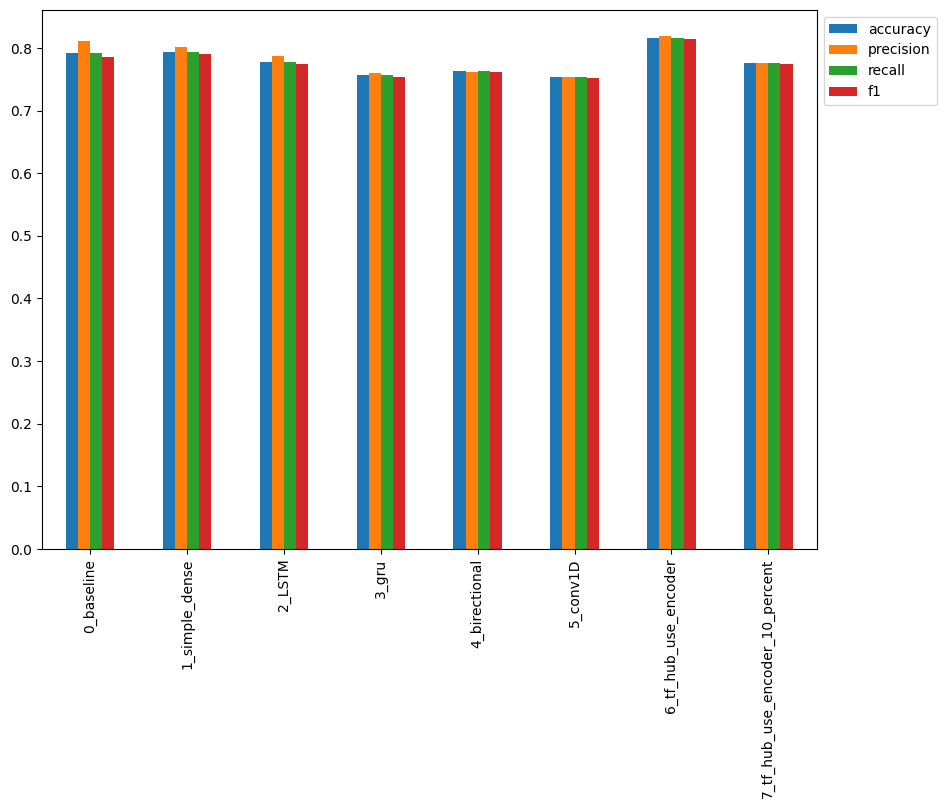

In [119]:
#Plot and compare all models results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

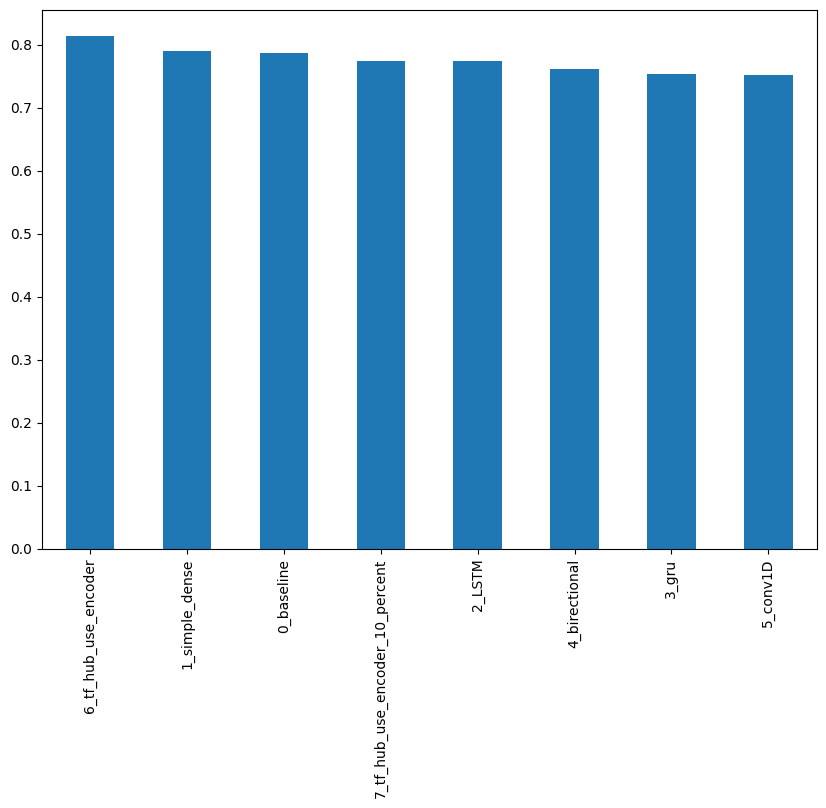

In [120]:
# Sort model results by f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Saving and loading a trained model
There are two main format to save a model to do in TF
* HDF5
* sAVED MODEL


In [122]:
#Save TF Hub Sentence Encodere model to HDF5 formaT
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [125]:
#Load the saved model with custum Hub layer
import tensorflow_hub as hub
loaded_model_6 = keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [126]:
#How does our loaded model performs
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 3s 24ms/step - loss: 0.4302 - accuracy: 0.8163


[0.4301556646823883, 0.8162729740142822]

In [127]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8197988627231594,
 'recall': 0.8162729658792651,
 'f1': 0.8143941941176971}

##Finding the most wrong example

If the sample should have a label of 0 but our model predicts a prediction probability of 0.999(close to 1) and vice versa


In [128]:
#Create a DF with validation sentences and best performinbg model prediction

!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2024-10-06 10:37:07--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.142.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  4.94MB/s    in 31s     

2024-10-06 10:37:38 (30.0 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables

In [129]:
#Import previously trained model from google
model_6_pretrained = keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [130]:
#Make prediction with the loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] #Therse should belabel format

24/24 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [138]:
#Create a DF with validations sentence,  va;idations_labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


* 0 - not_disaster
* 1 - disaster

In [139]:
#Find the wrong prediction and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positive

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [140]:
most_wrong.tail()#thewses are False negative

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [142]:
#Check the false positives (model predicted 1 when should be 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_probs}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [144]:
#Check the false positives (model predicted 1 when should be 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_probs}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730344891548157
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603394120931625
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963730275630951
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391848295927048
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

###Prediction on Test dataset

In [146]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [152]:
#Making predicytion test dataset and visualizing
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob=tf.squeeze(model_6_pretrained.predict([test_sample]))#Model expect list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----n")

1/1 [==============================] - 0s 48ms/step
Pred: 0, Prob: 0.09140447527170181
Text:
Womens Flower Printed Shoulder Handbags Cross Body Metal Chain Satchel Bags Pink http://t.co/vBZqWzNxH7 http://t.co/NXIhHeP1Ea

-----n
1/1 [==============================] - 0s 46ms/step
Pred: 0, Prob: 0.07819164544343948
Text:
SALHA(1):HARRY STYLES(2)U KNOW WHERE IS UR P_EOPLE#HURRY#EVACUATE THEM FROM#HELL.#JUST SHAHADA&amp;'PICK#ME'.#CLASS_SICK http://t.co/UpdDVr6jva

-----n
1/1 [==============================] - 0s 43ms/step
Pred: 1, Prob: 0.6174471974372864
Text:
.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes

-----n
1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.0750889703631401
Text:
[Serious]Now the Admins have banned certain volatile subreddits which ones are you surprised haven't been removed/quarantined yet? Û_

-----n
1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.11760606616735458
T

In [153]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8197988627231594,
 'recall': 0.8162729658792651,
 'f1': 0.8143941941176971}